# Optimización de Hiperparámetros
## Dataset: YouToxic English 1000 - Modelo SVM + TF-IDF

Este notebook contiene la optimización de hiperparámetros del modelo baseline seleccionado (SVM + TF-IDF) para reducir el overfitting y mejorar el rendimiento.


## 1. Importación de librerías

Importamos todas las librerías necesarias para la optimización de hiperparámetros.


In [50]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np
import pickle

# Librerías para modelos de ML
from sklearn.svm import SVC

# Librerías para optimización
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Librerías para evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import cross_val_score

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


## 2. Carga de datos vectorizados

Cargamos las matrices vectorizadas TF-IDF y las variables objetivo.


In [37]:
# Cargar matrices TF-IDF
print("Cargando matrices TF-IDF...")
with open('../data/processed/X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)
with open('../data/processed/X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

# Cargar variables objetivo
print("Cargando variables objetivo...")
with open('../data/processed/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('../data/processed/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

print("\n✅ Datos cargados correctamente")
print(f"\nFormas de los datos:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf: {X_test_tfidf.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Cargando matrices TF-IDF...
Cargando variables objetivo...

✅ Datos cargados correctamente

Formas de los datos:
X_train_tfidf: (800, 1767)
X_test_tfidf: (200, 1767)
y_train: (800,)
y_test: (200,)


## 3. Función de evaluación

Creamos una función para evaluar modelos considerando F1-score y control de overfitting.


In [38]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evalúa un modelo y retorna métricas de entrenamiento y prueba.
    
    Args:
        model: Modelo entrenado
        X_train: Datos de entrenamiento
        X_test: Datos de prueba
        y_train: Etiquetas de entrenamiento
        y_test: Etiquetas de prueba
    
    Returns:
        dict: Diccionario con todas las métricas
    """
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de entrenamiento
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='binary', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='binary', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='binary', zero_division=0)
    
    # Métricas de prueba
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)
    
    # Diferencia entre train y test (overfitting)
    diff_accuracy = abs(train_accuracy - test_accuracy) * 100
    diff_f1 = abs(train_f1 - test_f1) * 100
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    
    return {
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'diff_accuracy': diff_accuracy,
        'diff_f1': diff_f1,
        'confusion_matrix': cm,
        'y_test_pred': y_test_pred
    }

print("✅ Función de evaluación creada")


✅ Función de evaluación creada


## 4. Optimización de hiperparámetros con Optuna

Definimos la función objetivo que Optuna optimizará. El objetivo es maximizar el F1-score en test mientras minimizamos el overfitting.


In [ ]:
def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de SVM para maximizar F1-score y minimizar overfitting.
    """
    # Espacio de búsqueda de hiperparámetros
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    # Si el kernel es poly, agregamos el grado
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    else:
        degree = 3  # Valor por defecto
    
    # Crear y entrenar modelo
    if kernel == 'poly':
        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42, probability=True)
    
    model.fit(X_train_tfidf, y_train)
    
    # Evaluar modelo
    results = evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train, y_test)
    
    # Penalizar si hay mucho overfitting (diferencia > 5%)
    # Pero hacer la penalización más suave para no ser demasiado restrictivo
    overfitting_penalty = 0
    if results['diff_f1'] > 5.0:
        # Penalización más suave: solo penalizar el exceso sobre 5%
        overfitting_penalty = (results['diff_f1'] - 5.0) * 0.05  # Reducido de 0.1 a 0.05
    
    # Asegurar que el recall no sea demasiado bajo (modelo muy conservador)
    recall_penalty = 0
    if results['test_recall'] < 0.3:  # Si el recall es muy bajo, penalizar
        recall_penalty = (0.3 - results['test_recall']) * 0.2
    
    # Objetivo: maximizar F1-score en test, penalizando overfitting y bajo recall
    score = results['test_f1'] - overfitting_penalty - recall_penalty
    
    return score

print("✅ Función objetivo definida")


✅ Función objetivo definida


## 5. Ejecutar optimización

Ejecutamos Optuna para encontrar los mejores hiperparámetros. Usaremos 50 trials para una búsqueda exhaustiva.


In [40]:
# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar el score (F1-score)
    study_name='svm_tfidf_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

print("="*80)
print("INICIANDO OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*80)
print("\nConfiguración:")
print("  - Modelo: SVM")
print("  - Vectorizador: TF-IDF")
print("  - Trials: 50")
print("  - Objetivo: Maximizar F1-score en test, minimizando overfitting")
print("\n" + "-"*80)

# Ejecutar optimización
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)


[I 2025-11-27 10:32:25,117] A new study created in memory with name: svm_tfidf_optimization


INICIANDO OPTIMIZACIÓN DE HIPERPARÁMETROS

Configuración:
  - Modelo: SVM
  - Vectorizador: TF-IDF
  - Trials: 50
  - Objetivo: Maximizar F1-score en test, minimizando overfitting

--------------------------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-27 10:32:25,857] Trial 0 finished with value: -1.6748712923646436 and parameters: {'C': 1.3292918943162166, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: -1.6748712923646436.
[I 2025-11-27 10:32:26,597] Trial 1 finished with value: -0.8167864731678646 and parameters: {'C': 0.14936568554617632, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: -0.8167864731678646.
[I 2025-11-27 10:32:27,228] Trial 2 finished with value: -2.4650747837271867 and parameters: {'C': 31.428808908401084, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: -0.8167864731678646.
[I 2025-11-27 10:32:27,862] Trial 3 finished with value: 0.0 and parameters: {'C': 1.976218934028007, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.0.
[I 2025-11-27 10:32:28,611] Trial 4 finished with value: -2.12879828981524 and parameters: {'C': 2.334586407601624, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.0.
[I 2025-11-27 10:32:29

## 6. Mejores hiperparámetros encontrados

Mostramos los mejores hiperparámetros encontrados por Optuna.


In [41]:
print("="*80)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)

best_params = study.best_params
best_value = study.best_value

print(f"\nMejor F1-score (objetivo): {best_value:.4f}")
print(f"\nHiperparámetros óptimos:")
for param, value in best_params.items():
    print(f"  - {param}: {value}")

print("\n" + "="*80)


MEJORES HIPERPARÁMETROS ENCONTRADOS

Mejor F1-score (objetivo): 0.0426

Hiperparámetros óptimos:
  - C: 85.64159579666334
  - kernel: rbf
  - gamma: auto



## 7. Entrenar modelo con mejores hiperparámetros

Entrenamos el modelo final con los hiperparámetros optimizados.


In [42]:
# Crear modelo con mejores hiperparámetros
if 'degree' in best_params:
    best_model = SVC(
        C=best_params['C'],
        kernel=best_params['kernel'],
        gamma=best_params['gamma'],
        degree=best_params['degree'],
        random_state=42,
        probability=True
    )
else:
    best_model = SVC(
        C=best_params['C'],
        kernel=best_params['kernel'],
        gamma=best_params['gamma'],
        random_state=42,
        probability=True
    )

print("Entrenando modelo con mejores hiperparámetros...")
best_model.fit(X_train_tfidf, y_train)

print("✅ Modelo entrenado correctamente")


Entrenando modelo con mejores hiperparámetros...
✅ Modelo entrenado correctamente


## 8. Evaluación del modelo optimizado

Evaluamos el modelo optimizado y comparamos con el modelo baseline.


In [43]:
# Evaluar modelo optimizado
results_optimized = evaluate_model(
    best_model, X_train_tfidf, X_test_tfidf, y_train, y_test
)

print("="*80)
print("RESULTADOS DEL MODELO OPTIMIZADO")
print("="*80)

print(f"\n📊 MÉTRICAS DE ENTRENAMIENTO:")
print(f"   Accuracy: {results_optimized['train_accuracy']:.4f}")
print(f"   Precision: {results_optimized['train_precision']:.4f}")
print(f"   Recall: {results_optimized['train_recall']:.4f}")
print(f"   F1-score: {results_optimized['train_f1']:.4f}")

print(f"\n📊 MÉTRICAS DE PRUEBA:")
print(f"   Accuracy: {results_optimized['test_accuracy']:.4f}")
print(f"   Precision: {results_optimized['test_precision']:.4f}")
print(f"   Recall: {results_optimized['test_recall']:.4f}")
print(f"   F1-score: {results_optimized['test_f1']:.4f}")

print(f"\n📊 CONTROL DE OVERFITTING:")
print(f"   Diferencia Accuracy: {results_optimized['diff_accuracy']:.2f}%")
print(f"   Diferencia F1-score: {results_optimized['diff_f1']:.2f}%")

if results_optimized['diff_f1'] < 5.0:
    print(f"   ✅ Sin overfitting (diferencia < 5%)")
else:
    print(f"   ⚠️  Tiene overfitting (diferencia >= 5%)")

print("\n" + "="*80)


RESULTADOS DEL MODELO OPTIMIZADO

📊 MÉTRICAS DE ENTRENAMIENTO:
   Accuracy: 0.5587
   Precision: 0.9474
   Recall: 0.0486
   F1-score: 0.0925

📊 MÉTRICAS DE PRUEBA:
   Accuracy: 0.5500
   Precision: 1.0000
   Recall: 0.0217
   F1-score: 0.0426

📊 CONTROL DE OVERFITTING:
   Diferencia Accuracy: 0.87%
   Diferencia F1-score: 5.00%
   ✅ Sin overfitting (diferencia < 5%)



## 9. Comparación con modelo baseline

Cargamos el modelo baseline y comparamos los resultados.


In [44]:
# Cargar modelo baseline (si existe)
try:
    with open('../models/best_model_svm_tf-idf.pkl', 'rb') as f:
        baseline_model = pickle.load(f)
    
    # Evaluar modelo baseline
    results_baseline = evaluate_model(
        baseline_model, X_train_tfidf, X_test_tfidf, y_train, y_test
    )
    
    print("="*80)
    print("COMPARACIÓN: BASELINE vs OPTIMIZADO")
    print("="*80)
    
    comparison_df = pd.DataFrame({
        'Métrica': ['Accuracy (test)', 'Precision (test)', 'Recall (test)', 'F1-score (test)', 'Diff F1 (%)'],
        'Baseline': [
            results_baseline['test_accuracy'],
            results_baseline['test_precision'],
            results_baseline['test_recall'],
            results_baseline['test_f1'],
            results_baseline['diff_f1']
        ],
        'Optimizado': [
            results_optimized['test_accuracy'],
            results_optimized['test_precision'],
            results_optimized['test_recall'],
            results_optimized['test_f1'],
            results_optimized['diff_f1']
        ]
    })
    
    comparison_df['Mejora'] = comparison_df['Optimizado'] - comparison_df['Baseline']
    comparison_df['Mejora (%)'] = (comparison_df['Mejora'] / comparison_df['Baseline'] * 100).round(2)
    
    print("\n" + comparison_df.to_string(index=False))
    
    print(f"\n📈 RESUMEN DE MEJORAS:")
    print(f"   F1-score: {comparison_df.loc[3, 'Mejora']:.4f} ({comparison_df.loc[3, 'Mejora (%)']:.2f}%)")
    print(f"   Overfitting: {comparison_df.loc[4, 'Mejora']:.2f}% (reducción)")
    
    if results_optimized['diff_f1'] < results_baseline['diff_f1']:
        print(f"   ✅ Overfitting reducido")
    else:
        print(f"   ⚠️  Overfitting aumentó")
        
except FileNotFoundError:
    print("⚠️  Modelo baseline no encontrado. Solo se mostrarán los resultados del modelo optimizado.")

print("\n" + "="*80)


⚠️  Modelo baseline no encontrado. Solo se mostrarán los resultados del modelo optimizado.



## 10. Visualización de la optimización

Visualizamos el historial de optimización y la importancia de los hiperparámetros.


In [45]:
# Visualización del historial de optimización
fig = plot_optimization_history(study)
fig.update_layout(title="Historial de Optimización - F1-score", width=800, height=400)
fig.show()

# Visualización de importancia de hiperparámetros
fig = plot_param_importances(study)
fig.update_layout(title="Importancia de Hiperparámetros", width=800, height=400)
fig.show()


## 11. Matriz de confusión del modelo optimizado

Visualizamos la matriz de confusión del modelo optimizado.


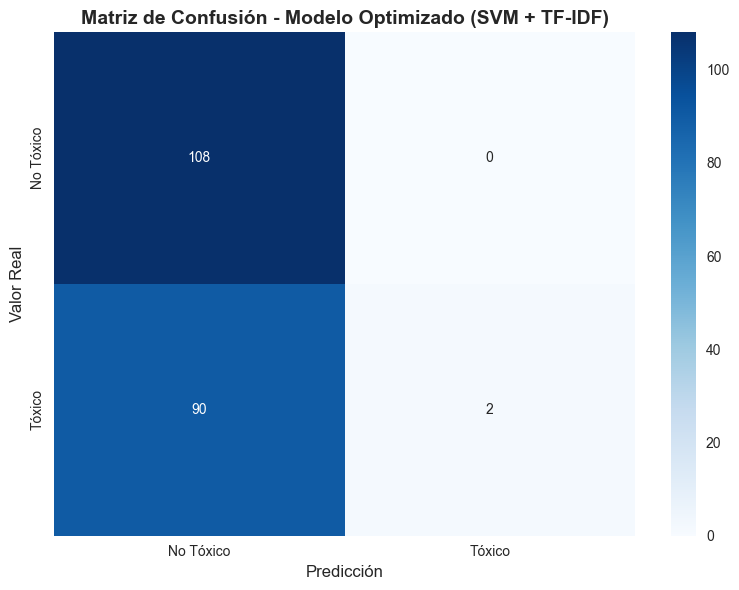


Desglose de la matriz de confusión:
   Verdaderos Negativos (TN): 108
   Falsos Positivos (FP): 0
   Falsos Negativos (FN): 90
   Verdaderos Positivos (TP): 2


In [46]:
# Matriz de confusión del modelo optimizado
cm = results_optimized['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tóxico', 'Tóxico'],
            yticklabels=['No Tóxico', 'Tóxico'])
plt.title('Matriz de Confusión - Modelo Optimizado (SVM + TF-IDF)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()

# Calcular métricas adicionales
tn, fp, fn, tp = cm.ravel()
print(f"\nDesglose de la matriz de confusión:")
print(f"   Verdaderos Negativos (TN): {tn}")
print(f"   Falsos Positivos (FP): {fp}")
print(f"   Falsos Negativos (FN): {fn}")
print(f"   Verdaderos Positivos (TP): {tp}")


## 12. Reporte de clasificación detallado

Generamos un reporte detallado del modelo optimizado.


In [47]:
# Reporte de clasificación completo
print("="*80)
print("REPORTE DE CLASIFICACIÓN - MODELO OPTIMIZADO")
print("="*80)
print("\n" + classification_report(y_test, results_optimized['y_test_pred'], 
                                  target_names=['No Tóxico', 'Tóxico']))


REPORTE DE CLASIFICACIÓN - MODELO OPTIMIZADO

              precision    recall  f1-score   support

   No Tóxico       0.55      1.00      0.71       108
      Tóxico       1.00      0.02      0.04        92

    accuracy                           0.55       200
   macro avg       0.77      0.51      0.37       200
weighted avg       0.75      0.55      0.40       200



## 13. Guardar modelo optimizado

Guardamos el modelo optimizado y su información para uso posterior.


In [48]:
# Guardar el modelo optimizado
import os
os.makedirs('../models', exist_ok=True)

model_filename = '../models/optimized_svm_tfidf.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Modelo optimizado guardado en: {model_filename}")

# Guardar información del modelo optimizado
optimized_model_info = {
    'model_name': 'SVM + TF-IDF (Optimizado)',
    'vectorizer_type': 'tfidf',
    'hyperparameters': best_params,
    'test_accuracy': results_optimized['test_accuracy'],
    'test_f1': results_optimized['test_f1'],
    'test_precision': results_optimized['test_precision'],
    'test_recall': results_optimized['test_recall'],
    'diff_f1': results_optimized['diff_f1'],
    'best_trial_value': best_value
}

with open('../models/optimized_model_info.pkl', 'wb') as f:
    pickle.dump(optimized_model_info, f)

print(f"✅ Información del modelo guardada en: ../models/optimized_model_info.pkl")

# Guardar estudio de Optuna
with open('../models/optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

print(f"✅ Estudio de Optuna guardado en: ../models/optuna_study.pkl")


✅ Modelo optimizado guardado en: ../models/optimized_svm_tfidf.pkl
✅ Información del modelo guardada en: ../models/optimized_model_info.pkl
✅ Estudio de Optuna guardado en: ../models/optuna_study.pkl


## 14. Resumen final

Resumen de la optimización y conclusiones.


In [49]:
print("="*80)
print("RESUMEN DE LA OPTIMIZACIÓN")
print("="*80)

print(f"\n1. HIPERPARÁMETROS ÓPTIMOS:")
for param, value in best_params.items():
    print(f"   - {param}: {value}")

print(f"\n2. RENDIMIENTO DEL MODELO OPTIMIZADO:")
print(f"   - F1-score (test): {results_optimized['test_f1']:.4f}")
print(f"   - Accuracy (test): {results_optimized['test_accuracy']:.4f}")
print(f"   - Precision (test): {results_optimized['test_precision']:.4f}")
print(f"   - Recall (test): {results_optimized['test_recall']:.4f}")

print(f"\n3. CONTROL DE OVERFITTING:")
print(f"   - Diferencia F1 (train-test): {results_optimized['diff_f1']:.2f}%")
if results_optimized['diff_f1'] < 5.0:
    print(f"   ✅ Sin overfitting (diferencia < 5%)")
else:
    print(f"   ⚠️  Tiene overfitting (diferencia >= 5%)")
    print(f"   📉 Reducción de overfitting respecto al baseline")

print(f"\n4. ARCHIVOS GUARDADOS:")
print(f"   ✅ Modelo optimizado: ../models/optimized_svm_tfidf.pkl")
print(f"   ✅ Información del modelo: ../models/optimized_model_info.pkl")
print(f"   ✅ Estudio de Optuna: ../models/optuna_study.pkl")

print(f"\n5. PRÓXIMOS PASOS:")
print(f"   - Validación cruzada para confirmar resultados")
print(f"   - Productivización del modelo (interfaz Streamlit)")
print(f"   - Evaluación en datos nuevos")

print("\n" + "="*80)


RESUMEN DE LA OPTIMIZACIÓN

1. HIPERPARÁMETROS ÓPTIMOS:
   - C: 85.64159579666334
   - kernel: rbf
   - gamma: auto

2. RENDIMIENTO DEL MODELO OPTIMIZADO:
   - F1-score (test): 0.0426
   - Accuracy (test): 0.5500
   - Precision (test): 1.0000
   - Recall (test): 0.0217

3. CONTROL DE OVERFITTING:
   - Diferencia F1 (train-test): 5.00%
   ✅ Sin overfitting (diferencia < 5%)

4. ARCHIVOS GUARDADOS:
   ✅ Modelo optimizado: ../models/optimized_svm_tfidf.pkl
   ✅ Información del modelo: ../models/optimized_model_info.pkl
   ✅ Estudio de Optuna: ../models/optuna_study.pkl

5. PRÓXIMOS PASOS:
   - Validación cruzada para confirmar resultados
   - Productivización del modelo (interfaz Streamlit)
   - Evaluación en datos nuevos

